# Calculate ocean thermal forcing from ECCOv4r4 data, direct from PO.DAAC S3 storage

This notebook calculates ocean thermal forcing from ECCOv4r4 data by reading the data directly from the PO.DAAC S3 data bucket on AWS us-west-2 region while working from a JupyterHub environment also located on us-est-2. In our case, us-est-2 is the same cloud center as the SMCE JupyterHub, where the EIS Sea Level project does a lot of work. By reading data directly from the S3 bucket, so do not have to maintain our own copy, and should not need to pay extra to work with that data.

### Configuring Earthdata Authentication

You will need to setup Earthdata authentication to successfully use the PO.DAAC S3 bucket. A set of functions are included below to facilitate this (compiled from multiple sources, listed below). You can automate authentication by creating a ".netrc" file in your home directory and writing the following:

```
machine urs.earthdata.nasa.gov
    login <earthdata username>
    password <earthdata password>
```

On the SMCE JupyterHub, it is recommended that you do this from a terminal. First make sure you are in your home directory (`cd ~`), then create a new file and include the following:

```
cat >> .netrc
machine urs.earthdata.nasa.gov
    login <username>
    password <password>

```

Press `Enter` and then type `Ctrl+C` to save and close the prompt.

> **⚠️ Warning:** After writing the file, we _**strongly**_ recommend setting the new `.netrc` file to read-only for only the user using `chmod 0400 .netrc`. If you later need to edit this file, you can temporarily allow read/write by only the user with `chmod 0600 .netrc`. **NOTE:** Some SMCE users have found that they must reset the 0400 permissions every time they start a new SMCE server. If you find this to be the case, you can simply add the correct command to your bash profile or else run the first cell in this notebook. Alternatively, you may wish to forego using a .netrc file altogether and instead use the login prompt below to authenticate each time you use this notebook. _However, that prompt appears to be broken at this time..._

If configured successfully, you should see the following output from the second notebook cell.

```
# Your URS credentials were securely retrieved from your .netrc file.
Earthdata login credentials configured. Ready.
```

Otherwise, you will see a message saying it could not use the .netrc file and it will ask you to input your username and password.

```
There's no .netrc file or the The endpoint isn't in the netrc file. Please provide...
# Your info will only be passed to urs.earthdata.nasa.gov and will not be exposed in Jupyter.
Username: 
```

---

*Note: There is a pip package called "earthdata" that is supposed to help with this process, primarily in reducing code that we must write. However, I (Mike Croteau) have not been able to get it to install on the SMCE. I've tried cloning the default environment and installing this extra package with conda, as suggested by the earthdata devs, but I get unresolvable package inconsistencies. If anyone can get this working, please share.*

---

Sources:

- [Use Case: Study Amazon Estuaries with Data from the EOSDIS Cloud](https://github.com/podaac/tutorials/blob/master/notebooks/SWOT-EA-2021/Estuary_explore_inCloud_zarr.ipynb)
- [SWOT Oceanography with PO.DAAC](https://git.mysmce.com/eis-sealevel/swot/-/blob/main/tutorials/.ipynb_checkpoints/SWOT_simulated_L2_SSH_introduction-checkpoint.ipynb)
- ["Update cloud_direct_access_s3.py" - podaac tutorials commit 4da70c7cf079ddd7a6de4c4345749f580ba66d71](https://github.com/podaac/tutorials/commit/4da70c7cf079ddd7a6de4c4345749f580ba66d71#)

In [1]:
!chmod 0400 ~/.netrc

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import progressbar

In [3]:
from urllib import request
from http.cookiejar import CookieJar
import netrc
import requests
import s3fs
import getpass

def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file 
    first and if no credentials are found, it prompts for them.
    Valid endpoints:
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
        print('# Your URS credentials were securely retrieved from your .netrc file.')
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print("There's no .netrc file or the The endpoint isn't in the netrc file. Please provide...")
        print('# Your info will only be passed to %s and will not be exposed in Jupyter.' % (endpoint))
        username = input('Username: ')
        password = getpass.getpass('Password: ')

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)
    
def begin_s3_direct_access():
    url="https://archive.podaac.earthdata.nasa.gov/s3credentials"
    r = requests.get(url)
    response = r.json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],secret=response['secretAccessKey'],token=response['sessionToken'],client_kwargs={'region_name':'us-west-2'})

edl = "urs.earthdata.nasa.gov"
setup_earthdata_login_auth(edl)
print('Earthdata login credentials configured. Ready.')

# Your URS credentials were securely retrieved from your .netrc file.
Earthdata login credentials configured. Ready.


## ECCO information and notes
Slides with info about the different ECCO versions:
https://events.ecmwf.int/event/199/contributions/1956/attachments/1109/2066/OceanDA21_Fenty.pdf

ECCOv4r4 data is here: https://podaac.jpl.nasa.gov/dataset/ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4
* This is hosted in Earthdata cloud

ECCOv5 data is here: https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha
* This is not hosted in the cloud and must be downloaded


Helpful (potentially) resources and tutorials:
* https://github.com/ECCO-GROUP/ECCO-v4-Python-Tutorial
* https://github.com/sea-level-change


## Setup
Set up the bounding box within which we'll calculate thermal forcing. First, we define an upper-left (ul) and a lower-right (lr) map location for the bounding box. Second, we define a minimum and maximum depth.

In [4]:
# Disko Bay
ul = [-53.4, 69.3]
lr = [-51.4, 68.7]

depth_min = -200
depth_max = -400


Define a function to calculate thermal forcing from latitude, depth, temperature, and salinity. We'll use the p_from_z function from the Python gsw package that approximates pressure as a function of depth and latitude.

In [5]:
import gsw

def thermal_forcing(lat, depth, theta, salt):
    # From Xu et al. (2012): https://doi.org/10.3189/2012AoG60A139
    
    # Local freezing point calculation
    a = -0.0575 # degC psu^-1
    b = 0.0901 # degC
    c = -7.61e-4 # degC dbar^-1
    
    rho_seawater = 1026 # kg m^-3
    g = 9.18 # m s^-2
    
    p = gsw.p_from_z(depth, lat) # dbar
    
    T_freeze = a*salt + b + c*p
    thermal_forcing = theta - T_freeze
    
    return thermal_forcing


## Initial check -- initiate S3 access and load one ECCO dataset

Here, we initiate S3 access, then use s3fs to tell us what netcdf files are available in the given S3 bucket (printing out the last 5 for good measure). Then we select the last file and load it using xarray. Alternatively, you could attempt to use "harmony" to convert it to zarr format and load things from there (see the first source document above for more details).

In [6]:
# Initiate PO.DAAC S3 connection
fs = begin_s3_direct_access()

Now, load one file (from Jan. 1992) to test whether we're able to read from S3. Plot the ECCO grid points and our bounding box.

Text(0.5, 1.0, 'ocean potential temp. at depth -222.710007 m')

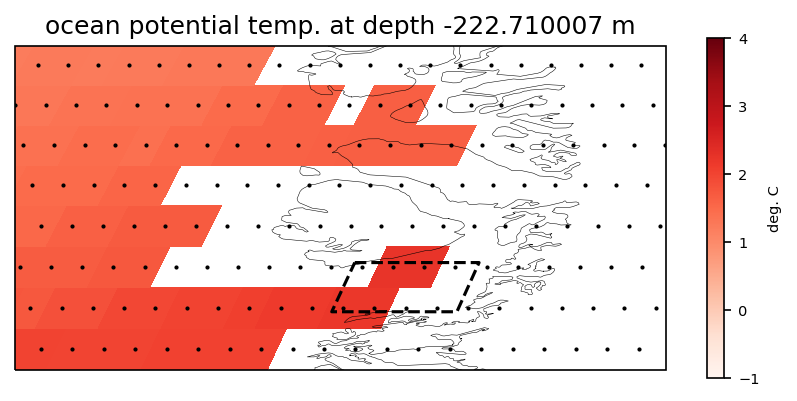

In [7]:
s3_bucket = 's3://podaac-ops-cumulus-protected/ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4/*1992-01*nc'
s3_files = fs.glob(s3_bucket)

file = fs.open(s3_files[0])
ds = xr.open_dataset(file)
depth = ds.Z.values
lat = ds.latitude.values
lon = ds.longitude.values
theta = ds.THETA.values[0,:,:]
ds.close()

# Plot
fig = plt.figure(figsize=(7,3), dpi=150)
ax = plt.axes(projection=ccrs.Robinson(), extent=[-58, -50, 68, 72])

z_level = 17
pc = ax.pcolormesh(lon, lat, theta[z_level,:,:], cmap=plt.cm.Reds, transform=ccrs.PlateCarree(), vmin=-1, vmax=+4)
ax.plot([ul[0], lr[0], lr[0], ul[0], ul[0]], [ul[1], ul[1], lr[1], lr[1], ul[1]], 'k--', markersize=5, zorder=100, transform=ccrs.PlateCarree())

lonm, latm = np.meshgrid(lon,lat)
ax.plot(lonm, latm, 'k.', markersize=2, transform=ccrs.PlateCarree())

c = plt.colorbar(pc)
c.ax.tick_params(labelsize=7)
c.set_label('deg. C', size=7)

ax.coastlines(resolution='10m', zorder=7, linewidth=0.25)

ax.set_title('ocean potential temp. at depth {:f} m'.format(depth[z_level]))

## Calculate ocean thermal forcing from monthly ECCOv4r4 data
Now the fun part: loop through all ECCO data and calculate monthly thermal forcing.

In [21]:
# Loop through files year by year
years = range(1992,2018)
for year in progressbar.progressbar(years):
    # Get list of ECCO files for given year
    s3_bucket = 's3://podaac-ops-cumulus-protected/ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4/*{:d}*nc'.format(year)
    s3_files = fs.glob(s3_bucket)

    # Create a fileset (a list of open files)
    fileset = [fs.open(file) for file in s3_files]

    # Open all files using xarray open_mfdataset
    ds = xr.open_mfdataset(fileset,
                               combine='by_coords',
                               mask_and_scale=True,
                               decode_cf=True,
                               chunks='auto')

    # Read in coordinate values
    depth = ds.Z.values
    lat = ds.latitude.values
    lon = ds.longitude.values

    # Subset by depth, lat, lon
    z_idx = np.where( (depth <= depth_min) & (depth >= depth_max) )[0]
    lon_idx = np.where( (lon >= ul[0]) * (lon <= lr[0]) )[0]
    lon_min = lon_idx[0]; lon_max = lon_idx[-1]+1
    lat_idx = np.where( (lat <= ul[1]) * (lat >= lr[1]) )[0]
    lat_min = lat_idx[0]; lat_max = lat_idx[-1]+1

    depth = depth[z_idx]
    lon = lon[lon_min:lon_max]
    lat = lat[lat_min:lat_max]
    
    # Loop through months of the year
    f = open('./Cheat_matfiles/ECCOv4r4_oceanTF_{:d}.txt'.format(year), 'w')
    for month in range(12):
        theta = ds.THETA[month, z_idx, lat_min:lat_max, lon_min:lon_max].values
        salt  = ds.SALT [month, z_idx, lat_min:lat_max, lon_min:lon_max].values
        
        # Calculate TF at every ECCO grid cell and depth
        TF = np.empty(theta.shape)
        for i in range(TF.shape[0]):
            for j in range(TF.shape[1]):
                for k in range(TF.shape[2]):
                    TF_ijk = thermal_forcing(lat[j], depth[i], theta[i,j,k], salt[i,j,k])
                    TF[i,j,k] = TF_ijk
                    
        # Write a text file with the average thermal forcing for this year    
        f.write('{:f} '.format(np.nanmean(TF, axis=(0,1,2))))
    
    # Close the text file
    f.close()
    
    # Close the dataset
    ds.close()
    

100% (2 of 2) |##########################| Elapsed Time: 0:00:47 Time:  0:00:47


## Example of how we would read the yearly files and create arrays with thermal forcing and time (fractional year)

Text(0, 0.5, 'TF (deg. C)')

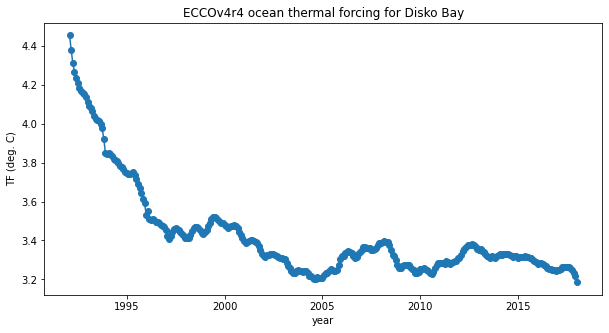

In [22]:
years = range(1992,2018)

# Initialize empty arrays with 26 x 12 months
time = np.array([])
TF_avg = np.array([])

# Loop through yearly files and add thermal forcing and times to array
for year in years:
    filename = './Cheat_matfiles/ECCOv4r4_oceanTF_{:d}.txt'.format(year)
    if os.path.isfile(filename):
        f = open(filename, 'r')
        lines = f.readlines()
        f.close()
        
        time = np.hstack( (time, [year + month/12 for month in range(1,13)]))
        TF_avg = np.hstack( (TF_avg, [float(TF) for TF in lines[0].split()]) )
    
    else:
        print('File missing: ' + filename)

fig = plt.figure(figsize=(10,5))
plt.plot(time, TF_avg, 'o-')
plt.title('ECCOv4r4 ocean thermal forcing for Disko Bay')
plt.xlabel('year')
plt.ylabel('TF (deg. C)')


## Compare TF from several different sources
We have ocean TF from Wood et al. (2021) for each glacier in the ROI, from EN4 (via the ISMIP6 project) for the continental shelf, and the TF that we've calculated in this notebook, which is an average within Disko Bay.

Text(0, 0.5, 'TF (deg. C)')

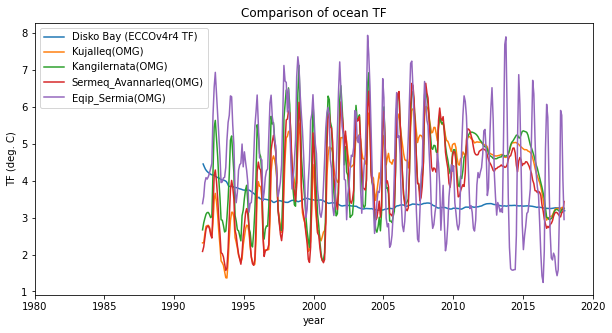

In [23]:
from scipy_io_utils import *
from netCDF4 import Dataset

glaciers = list()
glaciers.append( ['glacier0013','Kujalleq'] )
glaciers.append( ['glacier0052','Kangilernata'] )
glaciers.append( ['glacier0053','Sermeq_Avannarleq'] )
glaciers.append( ['glacier0090','Eqip_Sermia'] )

fig = plt.figure(figsize=(10,5))
plt.plot(time, TF_avg, label='Disko Bay (ECCOv4r4 TF)')

for glacier in glaciers:
    m = loadmat('Cheat_matfiles/' + glacier[0] + '.mat')
    #print(m[glacier[0]]['rignotname'])
    d = Dataset('Cheat_matfiles/' + glacier[1] + '_Thermal_Forcing_Timeseries_FINAL.nc', 'r')

    #plt.plot(m[glacier[0]]['EN4']['t'], m[glacier[0]]['EN4']['TF'], label=glacier[1]+' (EN4)')
    plt.plot(d['Model_Forcing']['Time'][:], d['Model_Forcing']['Thermal_Forcing'][:], label=glacier[1]+'(OMG)')
    plt.xlim(1980, 2020)
    plt.legend()

plt.title('Comparison of ocean TF')
plt.xlabel('year')
plt.ylabel('TF (deg. C)')
